In [42]:
# Import necessary libraries
import pandas as pd
import numpy as np
import db_utils, sqlalchemy
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import seaborn as sns
from scipy.stats import fisher_exact
from scipy import stats
import math
import os
import gzip
import re
import glob
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import math
plt.rcParams['pdf.fonttype'] = 42 # Set the fonttype to export fonts as font files
plt.rcParams['font.family'] = 'Arial'
#sns.set_palette("colorblind")
global_fontsize = 10
figsize = (3,3)
legend_fontsize = 8
bbox_to_anchor =(1.0, 1.0)

In [43]:
# Define savepath and define function to modify ticks and lables of the plots
save_path = '/Users/johgeist/Downloads/figure_publication_new2/'
def modify_ticks_and_labels(ax,x_major_multiple=None,x_minor_multiple=None,
                            y_major_multiple=None,y_minor_multiple=None,
                            fontsize=None):
    if x_major_multiple is not None:
        ax.tick_params(axis='x', which='both')
        ax.xaxis.set_major_locator(MultipleLocator(x_major_multiple))
        ax.xaxis.set_minor_locator(MultipleLocator(x_minor_multiple))
        plt.setp(ax.xaxis.get_majorticklines(), 'markersize', 5)
        plt.setp(ax.xaxis.get_majorticklines(), 'markeredgewidth', 2)
        plt.setp(ax.xaxis.get_minorticklines(), 'markersize', 3.5)
        plt.setp(ax.xaxis.get_minorticklines(), 'markeredgewidth', 2)
    if y_major_multiple is not None:
        ax.tick_params(axis='y', which='both')
        ax.yaxis.set_major_locator(MultipleLocator(y_major_multiple))
        ax.yaxis.set_minor_locator(MultipleLocator(y_minor_multiple))
        plt.setp(ax.yaxis.get_majorticklines(), 'markersize', 5)
        plt.setp(ax.yaxis.get_majorticklines(), 'markeredgewidth', 2)
        plt.setp(ax.yaxis.get_minorticklines(), 'markersize', 3.5)
        plt.setp(ax.yaxis.get_minorticklines(), 'markeredgewidth', 2)
    if fontsize is not None:
        plt.tick_params(axis= 'both', labelsize= fontsize, bottom= False)
    else:
        global global_fontsize
        plt.tick_params(axis= 'both', labelsize= global_fontsize, bottom= False)

In [44]:
# Import manually curated dataset of DDIs with ML features (also used as Training/Test dataset)
df = pd.read_csv('/Users/johgeist/Downloads/3did_project_dataframes_new/3did_Interactome_ProtCID_AF_IUPred_metrics_mc_set_for_ML_without_synthetic_constructs.csv')

In [46]:
len(df)

75

In [47]:
df.drop(columns=['DDI type', 'DDI approved']).columns.tolist()

['Num structures',
 'Num interchain structures',
 'Num intrachain structures',
 '3did score',
 '3did z-score',
 'Num res-res contacts',
 'Fraction structures interchain',
 'HuRI z-score',
 'BioPlex z-score',
 'Num crystal forms in cluster',
 'Min seq identity in cluster',
 'Num proteins in cluster',
 'Model confidence',
 'DockQ',
 'Avg IUPred Iface full seq',
 'Avg IUPred Iface cryst seq']

In [48]:
# set up a statistics DataFrame storing the results of a MWU test and a normaltest for all features in the DataFrame
# between the approved and non-approved DDI types
df_stats = pd.DataFrame(columns=['Criteria', 'mean_a', 'mean_na'])
df_stats['mean_a'] = [np.mean(df.loc[df['DDI approved'] == 1, i]) for i in df.drop(columns=['DDI type', 'DDI approved']).columns.tolist()]
df_stats['mean_na'] = [np.mean(df.loc[df['DDI approved'] == 0, i]) for i in df.drop(columns=['DDI type', 'DDI approved']).columns.tolist()]
df_stats['Criteria'] = df.drop(columns=['DDI type', 'DDI approved']).columns.tolist()

mannwu_results = []
normal_results = []
ttest_results = []
for feat in df.drop(columns=['DDI type', 'DDI approved']).columns.tolist():
    if feat in ['HuRI z-score', 'BioPlex z-score']:
        a = df.loc[df['DDI approved'] == 1, feat].dropna()
        na = df.loc[df['DDI approved'] == 0, feat].dropna()
        mannwu_results.append(stats.mannwhitneyu(a, na)[1])
        ttest_results.append(stats.ttest_ind(a, na)[1])
        normal_results.append([stats.normaltest(a)[1], stats.normaltest(na)[1]])
    else:
        a = df.loc[df['DDI approved'] == 1, feat]
        na = df.loc[df['DDI approved'] == 0, feat]
        mannwu_results.append(stats.mannwhitneyu(a, na)[1])
        ttest_results.append(stats.ttest_ind(a, na)[1])
        normal_results.append([stats.normaltest(a)[1], stats.normaltest(na)[1]])
df_stats['MannWhitneyU_pval'] = mannwu_results
df_stats['norm_distr'] = normal_results
df_stats['ttest_pval'] = ttest_results

df_stats

/var/folders/gv/nb7y89n11zb14h3c0y1b594w0000gn/T/ipykernel_3471/444846750.py:20: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  ttest_results.append(stats.ttest_ind(a, na)[1])
/opt/homebrew/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1633: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/opt/homebrew/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1738: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = kurtosis(a, axis, fisher=False)


,Criteria,mean_a,mean_na,MannWhitneyU_pval,norm_distr,ttest_pval
0,Num structures,7.479167,12.740741,9.772716e-01,"[2.242017475705151e-14, 2.362781058091932e-11]",0.308111
1,Num interchain structures,7.479167,5.555556,7.409855e-01,"[2.242017475705151e-14, 8.323714834013841e-07]",0.506326
2,Num intrachain structures,0.000000,7.185185,6.789999e-03,"[nan, 2.459043700236095e-13]",0.068473
3,3did score,11.016667,4.048519,5.014440e-06,"[2.3706225257401705e-09, 1.5848740309131914e-06]",0.000242
4,3did z-score,4.587327,2.919088,2.422012e-05,"[0.0002184221705861941, 0.01906307699939058]",0.000048
5,Num res-res contacts,29.375000,11.518519,7.622766e-07,"[1.589568936209658e-06, 1.640064809336382e-06]",0.000043
6,Fraction structures interchain,1.000000,0.898738,6.789999e-03,"[nan, 4.466384340014067e-06]",0.006995
7,HuRI z-score,3.573094,1.802446,1.417342e-01,"[5.709007535214449e-11, 8.936231334201269e-08]",0.305668
8,BioPlex z-score,11.111575,9.307247,4.109202e-01,"[0.013579555593151025, 4.827360992552599e-06]",0.635450
9,Num crystal forms in cluster,6.229167,8.518519,4.657848e-01,"[2.743955560673581e-10, 7.08851543353406e-10]",0.513612


In [49]:
# Add a column translating the pvalues into asteriks notation
df_stats.loc[df_stats['MannWhitneyU_pval'] >=0.05, 'significancy_MWU'] = 'ns'
df_stats.loc[(df_stats['MannWhitneyU_pval'] <0.05) & (df_stats['MannWhitneyU_pval'] >=0.01),
             'significancy_MWU'] = '*'
df_stats.loc[(df_stats['MannWhitneyU_pval'] <0.01) & (df_stats['MannWhitneyU_pval'] >=0.001),
             'significancy_MWU'] = '**'
df_stats.loc[df_stats['MannWhitneyU_pval'] <0.001, 'significancy_MWU'] = '***'

df_stats.loc[df_stats['ttest_pval'] >=0.05, 'significancy_ttest'] = 'ns'
df_stats.loc[(df_stats['ttest_pval'] <0.05) & (df_stats['ttest_pval'] >=0.01),
             'significancy_ttest'] = '*'
df_stats.loc[(df_stats['ttest_pval'] <0.01) & (df_stats['ttest_pval'] >=0.001),
             'significancy_ttest'] = '**'
df_stats.loc[df_stats['ttest_pval'] <0.001, 'significancy_ttest'] = '***'

In [50]:
# add a binary column for assessing the normal distribution of the datapoints in the approved and non-approved group
df_stats['not_normally_distr'] = df_stats['norm_distr'].apply(lambda x: any(value < 0.05 for value in x))

In [51]:
df_stats

,Criteria,mean_a,mean_na,MannWhitneyU_pval,norm_distr,ttest_pval,significancy_MWU,significancy_ttest,not_normally_distr
0,Num structures,7.479167,12.740741,9.772716e-01,"[2.242017475705151e-14, 2.362781058091932e-11]",0.308111,ns,ns,True
1,Num interchain structures,7.479167,5.555556,7.409855e-01,"[2.242017475705151e-14, 8.323714834013841e-07]",0.506326,ns,ns,True
2,Num intrachain structures,0.000000,7.185185,6.789999e-03,"[nan, 2.459043700236095e-13]",0.068473,**,ns,True
3,3did score,11.016667,4.048519,5.014440e-06,"[2.3706225257401705e-09, 1.5848740309131914e-06]",0.000242,***,***,True
4,3did z-score,4.587327,2.919088,2.422012e-05,"[0.0002184221705861941, 0.01906307699939058]",0.000048,***,***,True
5,Num res-res contacts,29.375000,11.518519,7.622766e-07,"[1.589568936209658e-06, 1.640064809336382e-06]",0.000043,***,***,True
6,Fraction structures interchain,1.000000,0.898738,6.789999e-03,"[nan, 4.466384340014067e-06]",0.006995,**,**,True
7,HuRI z-score,3.573094,1.802446,1.417342e-01,"[5.709007535214449e-11, 8.936231334201269e-08]",0.305668,ns,ns,True
8,BioPlex z-score,11.111575,9.307247,4.109202e-01,"[0.013579555593151025, 4.827360992552599e-06]",0.635450,ns,ns,True
9,Num crystal forms in cluster,6.229167,8.518519,4.657848e-01,"[2.743955560673581e-10, 7.08851543353406e-10]",0.513612,ns,ns,True


In [52]:
# print features with significant difference for approved and non-approved DDI types
df_stats[df_stats['MannWhitneyU_pval'] < 0.05]

,Criteria,mean_a,mean_na,MannWhitneyU_pval,norm_distr,ttest_pval,significancy_MWU,significancy_ttest,not_normally_distr
2,Num intrachain structures,0.000000,7.185185,6.789999e-03,"[nan, 2.459043700236095e-13]",0.068473,**,ns,True
3,3did score,11.016667,4.048519,5.014440e-06,"[2.3706225257401705e-09, 1.5848740309131914e-06]",0.000242,***,***,True
4,3did z-score,4.587327,2.919088,2.422012e-05,"[0.0002184221705861941, 0.01906307699939058]",0.000048,***,***,True
5,Num res-res contacts,29.375000,11.518519,7.622766e-07,"[1.589568936209658e-06, 1.640064809336382e-06]",0.000043,***,***,True
6,Fraction structures interchain,1.000000,0.898738,6.789999e-03,"[nan, 4.466384340014067e-06]",0.006995,**,**,True
13,DockQ,0.419229,0.101593,4.018719e-05,"[3.641411421577991e-14, 9.941829259777236e-10]",0.000036,***,***,True
15,Avg IUPred Iface cryst seq,0.241819,0.345180,4.479977e-03,"[0.44246312341167326, 0.3636966310458153]",0.001438,**,**,False


In [53]:
# 3did plots

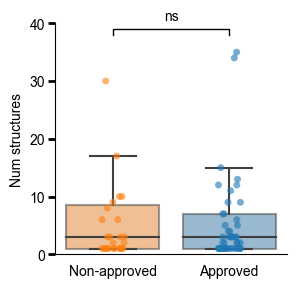

In [54]:
filtered_df = df_stats[df_stats['Criteria']== 'Num structures']

fig, axes = plt.subplots(figsize=(3,3))

my_pal1 = {'0.0': "tab:orange", '1.0': "tab:blue"}
my_pal = {0: "tab:orange", 1: "tab:blue"}

sns.stripplot(x= 'DDI approved', y= 'Num structures', data = df, alpha= 0.6, ax= axes, palette= my_pal, hue = 'DDI approved')
sns.boxplot(x= 'DDI approved', y= 'Num structures', data = df,  showfliers= False, boxprops=dict(alpha=0.5), ax= axes, palette= my_pal)
axes.set_ylim(0,40) # misses 9 datapoints
axes.set_ylabel('Num structures', fontsize= 10)
axes.set_xlabel('')
axes.set_xticklabels(labels=['Non-approved', 'Approved'], fontsize= 10)
axes.get_legend().remove()
modify_ticks_and_labels(axes, y_major_multiple= 10, y_minor_multiple= 10)

# Remove the top and right spines
sns.despine(top=True, right=True)

x1, x2 = 0, 1 
y, h, col = 38, 1, 'k'
axes.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.0, c=col)
axes.text((x1+x2)*.5, y+h+1,  str(filtered_df.at[filtered_df.index[0], 'significancy_MWU']), ha='center', va='bottom', color=col)

plt.savefig(f'{save_path}n_supporting_structures_3did_for_approved_and_non-approved_DDI_types.pdf', transparent=True, bbox_inches='tight')
plt.show()

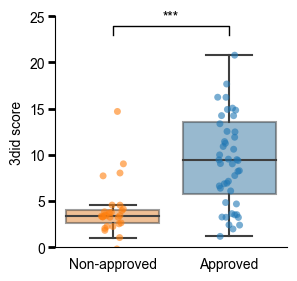

In [55]:
filtered_df = df_stats[df_stats['Criteria']== '3did score']

fig, axes = plt.subplots(figsize=(3,3))

my_pal1 = {'0.0': "tab:orange", '1.0': "tab:blue"}
my_pal = {0: "tab:orange", 1: "tab:blue"}

sns.stripplot(x= 'DDI approved', y= '3did score', data = df, alpha= 0.6, ax= axes, palette= my_pal, hue = 'DDI approved')
sns.boxplot(x= 'DDI approved', y= '3did score', data = df,  showfliers= False, boxprops=dict(alpha=0.5), ax= axes, palette= my_pal)
axes.set_ylim(0,25) # misses 3 datapoints
axes.set_ylabel('3did score', fontsize= 10)
axes.set_xlabel('')
axes.set_xticklabels(labels=['Non-approved', 'Approved'], fontsize= 10)
axes.get_legend().remove()
modify_ticks_and_labels(axes, y_major_multiple= 5, y_minor_multiple= 5)

# Remove the top and right spines
sns.despine(top=True, right=True)

x1, x2 = 0, 1 
y, h, col = 23, 1, 'k'
axes.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.0, c=col)
axes.text((x1+x2)*.5, y+h+0.25,  str(filtered_df.at[filtered_df.index[0], 'significancy_MWU']), ha='center', va='bottom', color=col)

plt.savefig(f'{save_path}Score_max_3did_for_approved_and_non-approved_DDI_types.pdf', transparent=True, bbox_inches='tight')
plt.show()

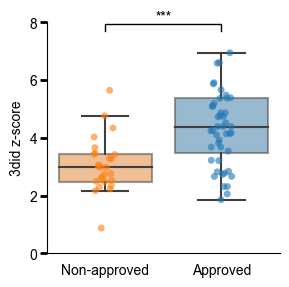

In [56]:
filtered_df = df_stats[df_stats['Criteria']== '3did z-score']

fig, axes = plt.subplots(figsize=(3,3))

my_pal1 = {'0.0': "tab:orange", '1.0': "tab:blue"}
my_pal = {0: "tab:orange", 1: "tab:blue"}

sns.stripplot(x= 'DDI approved', y= '3did z-score', data = df, alpha= 0.6, ax= axes, palette= my_pal, hue = 'DDI approved')
sns.boxplot(x= 'DDI approved', y= '3did z-score', data = df,  showfliers= False, boxprops=dict(alpha=0.5), ax= axes, palette= my_pal)
axes.set_ylim(0,8) # misses 3 datapoints
axes.set_ylabel('3did z-score', fontsize= 10)
axes.set_xlabel('')
axes.set_xticklabels(labels=['Non-approved', 'Approved'], fontsize= 10)
axes.get_legend().remove()
modify_ticks_and_labels(axes, y_major_multiple= 2, y_minor_multiple= 2)

# Remove the top and right spines
sns.despine(top=True, right=True)

x1, x2 = 0, 1 
y, h, col = 7.7, 0.25, 'k'
axes.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.0, c=col)
axes.text((x1+x2)*.5, y+h+0.02,  str(filtered_df.at[filtered_df.index[0], 'significancy_MWU']), ha='center', va='bottom', color=col)

plt.savefig(f'{save_path}Zscore_max_3did_for_approved_and_non-approved_DDI_types.pdf', transparent=True, bbox_inches='tight')
plt.show()

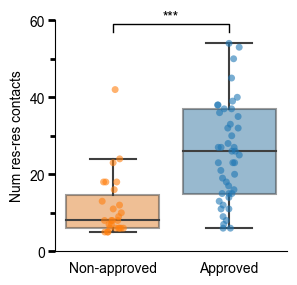

In [57]:
filtered_df = df_stats[df_stats['Criteria']== 'Num res-res contacts']

fig, axes = plt.subplots(figsize=(3,3))

my_pal1 = {'0.0': "tab:orange", '1.0': "tab:blue"}
my_pal = {0: "tab:orange", 1: "tab:blue"}

sns.stripplot(x= 'DDI approved', y= 'Num res-res contacts', data = df, alpha= 0.6, ax= axes, palette= my_pal, hue = 'DDI approved')
sns.boxplot(x= 'DDI approved', y= 'Num res-res contacts', data = df,  showfliers= False, boxprops=dict(alpha=0.5), ax= axes, palette= my_pal)
axes.set_ylim(0,60) # misses 3 datapoints
axes.set_ylabel('Num res-res contacts', fontsize= 10)
axes.set_xlabel('')
axes.set_xticklabels(labels=['Non-approved', 'Approved'], fontsize= 10)
axes.get_legend().remove()
modify_ticks_and_labels(axes, y_major_multiple= 20, y_minor_multiple= 10)

# Remove the top and right spines
sns.despine(top=True, right=True)

x1, x2 = 0, 1 
y, h, col = 57, 2, 'k'
axes.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.0, c=col)
axes.text((x1+x2)*.5, y+h+0.25,  str(filtered_df.at[filtered_df.index[0], 'significancy_MWU']), ha='center', va='bottom', color=col)

plt.savefig(f'{save_path}Max_n_res-res_contacts_3did_for_approved_and_non-approved_DDI_types.pdf', transparent=True, bbox_inches='tight')
plt.show()

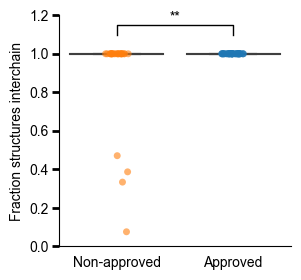

In [58]:
filtered_df = df_stats[df_stats['Criteria']== 'Fraction structures interchain']

fig, axes = plt.subplots(figsize=(3,3))

my_pal1 = {'0.0': "tab:orange", '1.0': "tab:blue"}
my_pal = {0: "tab:orange", 1: "tab:blue"}

sns.stripplot(x= 'DDI approved', y= 'Fraction structures interchain', data = df, alpha= 0.6, ax= axes, palette= my_pal, hue = 'DDI approved')
sns.boxplot(x= 'DDI approved', y= 'Fraction structures interchain', data = df,  showfliers= False, boxprops=dict(alpha=0.5), ax= axes, palette= my_pal)
axes.set_ylim(0,1.2)
axes.set_ylabel('Fraction structures interchain', fontsize= 10)
axes.set_xlabel('')
axes.set_xticklabels(labels=['Non-approved', 'Approved'], fontsize= 10)
axes.get_legend().remove()
modify_ticks_and_labels(axes, y_major_multiple= 0.2, y_minor_multiple= 0.2)

# Remove the top and right spines
sns.despine(top=True, right=True)

x1, x2 = 0, 1 
y, h, col = 1.1, 0.05, 'k'
axes.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.0, c=col)
axes.text((x1+x2)*.5, y+h+0.005,  str(filtered_df.at[filtered_df.index[0], 'significancy_MWU']), ha='center', va='bottom', color=col)

plt.savefig(f'{save_path}Fix_Interchain_fraction_3did_for_approved_and_non-approved_DDI_types.pdf', transparent=True, bbox_inches='tight')
plt.show()

In [59]:
#Interactome data plots

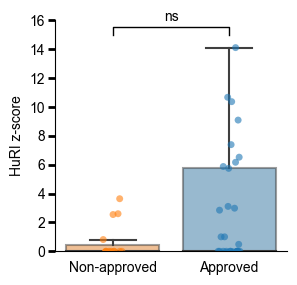

In [60]:
filtered_df = df_stats[df_stats['Criteria']== 'HuRI z-score']

fig, axes = plt.subplots(figsize=(3,3))

my_pal1 = {'0.0': "tab:orange", '1.0': "tab:blue"}
my_pal = {0: "tab:orange", 1: "tab:blue"}

sns.stripplot(x= 'DDI approved', y= 'HuRI z-score', data = df, alpha= 0.6, ax= axes, palette= my_pal, hue = 'DDI approved')
sns.boxplot(x= 'DDI approved', y= 'HuRI z-score', data = df,  showfliers= False, boxprops=dict(alpha=0.5), ax= axes, palette= my_pal)
axes.set_ylim(0,16) # misses 4 datapoints
axes.set_ylabel('HuRI z-score', fontsize= 10)
axes.set_xlabel('')
axes.set_xticklabels(labels=['Non-approved', 'Approved'], fontsize= 10)
axes.get_legend().remove()
modify_ticks_and_labels(axes, y_major_multiple= 2, y_minor_multiple= 2)

# Remove the top and right spines
sns.despine(top=True, right=True)

x1, x2 = 0, 1 
y, h, col = 15, 0.5, 'k'
axes.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.0, c=col)
axes.text((x1+x2)*.5, y+h+0.25,  str(filtered_df.at[filtered_df.index[0], 'significancy_MWU']), ha='center', va='bottom', color=col)

plt.savefig(f'{save_path}HuRIzscore_for_approved_and_non-approved_DDI_types.pdf', transparent=True, bbox_inches='tight')
plt.show()

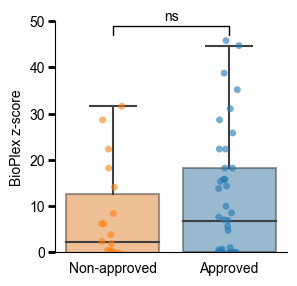

In [61]:
filtered_df = df_stats[df_stats['Criteria']== 'BioPlex z-score']

fig, axes = plt.subplots(figsize=(3,3))

my_pal1 = {'0.0': "tab:orange", '1.0': "tab:blue"}
my_pal = {0: "tab:orange", 1: "tab:blue"}

sns.stripplot(x= 'DDI approved', y= 'BioPlex z-score', data = df, alpha= 0.6, ax= axes, palette= my_pal, hue = 'DDI approved')
sns.boxplot(x= 'DDI approved', y= 'BioPlex z-score', data = df,  showfliers= False, boxprops=dict(alpha=0.5), ax= axes, palette= my_pal)
axes.set_ylim(0,50) # misses 1 datapoint
axes.set_ylabel('BioPlex z-score', fontsize= 10)
axes.set_xlabel('')
axes.set_xticklabels(labels=['Non-approved', 'Approved'], fontsize= 10)
axes.get_legend().remove()
modify_ticks_and_labels(axes, y_major_multiple= 10, y_minor_multiple= 10)

# Remove the top and right spines
sns.despine(top=True, right=True)

x1, x2 = 0, 1 
y, h, col = 47, 2, 'k'
axes.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.0, c=col)
axes.text((x1+x2)*.5, y+h+0.5,  str(filtered_df.at[filtered_df.index[0], 'significancy_MWU']), ha='center', va='bottom', color=col)

plt.savefig(f'{save_path}BioPlexzscore_for_approved_and_non-approved_DDI_types.pdf', transparent=True, bbox_inches='tight')
plt.show()

In [62]:
#ProtCID plots

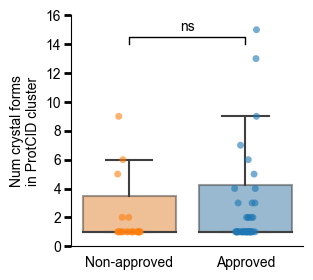

In [63]:
filtered_df = df_stats[df_stats['Criteria']== 'Num crystal forms in cluster']

fig, axes = plt.subplots(figsize=(3,3))

my_pal1 = {'0.0': "tab:orange", '1.0': "tab:blue"}
my_pal = {0: "tab:orange", 1: "tab:blue"}

sns.stripplot(x= 'DDI approved', y= 'Num crystal forms in cluster', data = df, alpha= 0.6, ax= axes, palette= my_pal, hue = 'DDI approved')
sns.boxplot(x= 'DDI approved', y= 'Num crystal forms in cluster', data = df,  showfliers= False, boxprops=dict(alpha=0.5), ax= axes, palette= my_pal)
axes.set_ylim(0,16) # misses 10 datapoints
axes.set_ylabel('Num crystal forms\nin ProtCID cluster', fontsize= 10)
axes.set_xlabel('')
axes.set_xticklabels(labels=['Non-approved', 'Approved'], fontsize= 10)
axes.get_legend().remove()
modify_ticks_and_labels(axes, y_major_multiple= 2, y_minor_multiple= 2)

# Remove the top and right spines
sns.despine(top=True, right=True)

x1, x2 = 0, 1 
y, h, col = 14, 0.5, 'k'
axes.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.0, c=col)
axes.text((x1+x2)*.5, y+h+0.25,  str(filtered_df.at[filtered_df.index[0], 'significancy_MWU']), ha='center', va='bottom', color=col)

plt.savefig(f'{save_path}Max_n_crystal_forms_ProtCID_for_approved_and_non-approved_DDI_types.pdf', transparent=True, bbox_inches='tight')
plt.show()

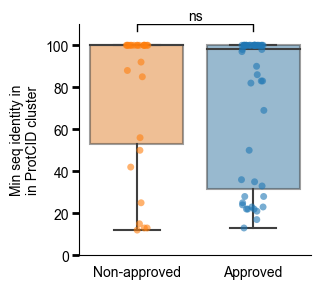

In [64]:
filtered_df = df_stats[df_stats['Criteria']== 'Min seq identity in cluster']

fig, axes = plt.subplots(figsize=(3,3))

my_pal1 = {'0.0': "tab:orange", '1.0': "tab:blue"}
my_pal = {0: "tab:orange", 1: "tab:blue"}

sns.stripplot(x= 'DDI approved', y= 'Min seq identity in cluster', data = df, alpha= 0.6, ax= axes, palette= my_pal, hue = 'DDI approved')
sns.boxplot(x= 'DDI approved', y= 'Min seq identity in cluster', data = df,  showfliers= False, boxprops=dict(alpha=0.5), ax= axes, palette= my_pal)
axes.set_ylim(0,110)
axes.set_ylabel('Min seq identity in\nin ProtCID cluster', fontsize= 10)
axes.set_xlabel('')
axes.set_xticklabels(labels=['Non-approved', 'Approved'], fontsize= 10)
axes.get_legend().remove()
modify_ticks_and_labels(axes, y_major_multiple= 20, y_minor_multiple= 20)

# Remove the top and right spines
sns.despine(top=True, right=True)

x1, x2 = 0, 1 
y, h, col = 107, 3, 'k'
axes.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.0, c=col)
axes.text((x1+x2)*.5, y+h+0.5,  str(filtered_df.at[filtered_df.index[0], 'significancy_MWU']), ha='center', va='bottom', color=col)

plt.savefig(f'{save_path}Minimal_seq_identity_ProtCID_for_approved_and_non-approved_DDI_types.pdf', transparent=True, bbox_inches='tight')
plt.show()

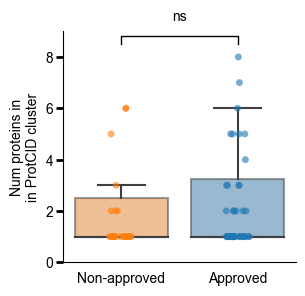

In [65]:
filtered_df = df_stats[df_stats['Criteria']== 'Num proteins in cluster']

fig, axes = plt.subplots(figsize=(3,3))

my_pal1 = {'0.0': "tab:orange", '1.0': "tab:blue"}
my_pal = {0: "tab:orange", 1: "tab:blue"}

sns.stripplot(x= 'DDI approved', y= 'Num proteins in cluster', data = df, alpha= 0.6, ax= axes, palette= my_pal, hue = 'DDI approved')
sns.boxplot(x= 'DDI approved', y= 'Num proteins in cluster', data = df,  showfliers= False, boxprops=dict(alpha=0.5), ax= axes, palette= my_pal)
axes.set_ylim(0,9) # misses 7 datapoints
axes.set_ylabel('Num proteins in\nin ProtCID cluster', fontsize= 10)
axes.set_xlabel('')
axes.set_xticklabels(labels=['Non-approved', 'Approved'], fontsize= 10)
axes.get_legend().remove()
modify_ticks_and_labels(axes, y_major_multiple= 2, y_minor_multiple= 2)

# Remove the top and right spines
sns.despine(top=True, right=True)

x1, x2 = 0, 1 
y, h, col = 8.5, 0.3, 'k'
axes.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.0, c=col)
axes.text((x1+x2)*.5, y+h+0.5,  str(filtered_df.at[filtered_df.index[0], 'significancy_MWU']), ha='center', va='bottom', color=col)

plt.savefig(f'{save_path}Max_n_of_proteins_ProtCID_for_approved_and_non-approved_DDI_types.pdf', transparent=True, bbox_inches='tight')
plt.show()

In [66]:
# AlphaFold plots

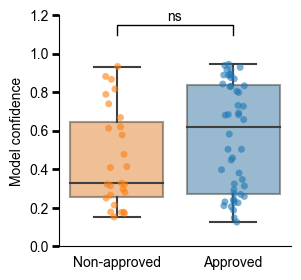

In [67]:
filtered_df = df_stats[df_stats['Criteria']== 'Model confidence']

fig, axes = plt.subplots(figsize=(3,3))

my_pal1 = {'0.0': "tab:orange", '1.0': "tab:blue"}
my_pal = {0: "tab:orange", 1: "tab:blue"}

sns.stripplot(x= 'DDI approved', y= 'Model confidence', data = df, alpha= 0.6, ax= axes, palette= my_pal, hue = 'DDI approved')
sns.boxplot(x= 'DDI approved', y= 'Model confidence', data = df,  showfliers= False, boxprops=dict(alpha=0.5), ax= axes, palette= my_pal)
axes.set_ylim(0,1.2)
axes.set_ylabel('Model confidence', fontsize= 10)
axes.set_xlabel('')
axes.set_xticklabels(labels=['Non-approved', 'Approved'], fontsize= 10)
axes.get_legend().remove()
modify_ticks_and_labels(axes, y_major_multiple= 0.2, y_minor_multiple= 0.2)

# Remove the top and right spines
sns.despine(top=True, right=True)

x1, x2 = 0, 1 
y, h, col = 1.1, 0.05, 'k'
axes.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.0, c=col)
axes.text((x1+x2)*.5, y+h+0.005,  str(filtered_df.at[filtered_df.index[0], 'significancy_MWU']), ha='center', va='bottom', color=col)

plt.savefig(f'{save_path}Fix_Max_model_confidence_AF_for_approved_and_non-approved_DDI_types.pdf', transparent=True, bbox_inches='tight')
plt.show()

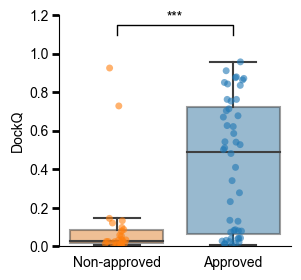

In [68]:
filtered_df = df_stats[df_stats['Criteria']== 'DockQ']

fig, axes = plt.subplots(figsize=(3,3))

my_pal1 = {'0.0': "tab:orange", '1.0': "tab:blue"}
my_pal = {0: "tab:orange", 1: "tab:blue"}

sns.stripplot(x= 'DDI approved', y= 'DockQ', data = df, alpha= 0.6, ax= axes, palette= my_pal, hue = 'DDI approved')
sns.boxplot(x= 'DDI approved', y= 'DockQ', data = df,  showfliers= False, boxprops=dict(alpha=0.5), ax= axes, palette= my_pal)
axes.set_ylim(0,1.2)
axes.set_ylabel('DockQ', fontsize= 10)
axes.set_xlabel('')
axes.set_xticklabels(labels=['Non-approved', 'Approved'], fontsize= 10)
axes.get_legend().remove()
modify_ticks_and_labels(axes, y_major_multiple= 0.2, y_minor_multiple= 0.2)

# Remove the top and right spines
sns.despine(top=True, right=True)

x1, x2 = 0, 1 
y, h, col = 1.1, 0.05, 'k'
axes.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.0, c=col)
axes.text((x1+x2)*.5, y+h+0.005,  str(filtered_df.at[filtered_df.index[0], 'significancy_MWU']), ha='center', va='bottom', color=col)

plt.savefig(f'{save_path}Fix_Max DockQ_AF_for_approved_and_non-approved_DDI_types.pdf', transparent=True, bbox_inches='tight')
plt.show()

In [69]:
# IUPred plots

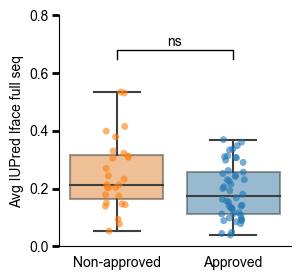

In [70]:
filtered_df = df_stats[df_stats['Criteria']== 'Avg IUPred Iface full seq']

fig, axes = plt.subplots(figsize=(3,3))

my_pal1 = {'0.0': "tab:orange", '1.0': "tab:blue"}
my_pal = {0: "tab:orange", 1: "tab:blue"}

sns.stripplot(x= 'DDI approved', y= 'Avg IUPred Iface full seq', data = df, alpha= 0.6, ax= axes, palette= my_pal, hue = 'DDI approved')
sns.boxplot(x= 'DDI approved', y= 'Avg IUPred Iface full seq', data = df,  showfliers= False, boxprops=dict(alpha=0.5), ax= axes, palette= my_pal)
axes.set_ylim(0,0.8)
axes.set_ylabel('Avg IUPred Iface full seq', fontsize= 10)
axes.set_xlabel('')
axes.set_xticklabels(labels=['Non-approved', 'Approved'], fontsize= 10)
axes.get_legend().remove()
modify_ticks_and_labels(axes, y_major_multiple= 0.2, y_minor_multiple= 0.2)

# Remove the top and right spines
sns.despine(top=True, right=True)

x1, x2 = 0, 1 
y, h, col = 0.65, 0.03, 'k'
axes.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.0, c=col)
axes.text((x1+x2)*.5, y+h+0.005,  str(filtered_df.at[filtered_df.index[0], 'significancy_MWU']), ha='center', va='bottom', color=col)

plt.savefig(f'{save_path}Avg_IUPred_Iface_full_seq_for_approved_and_non-approved_DDI_types.pdf', transparent=True, bbox_inches='tight')
plt.show()

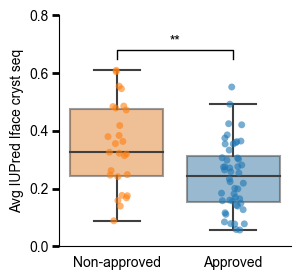

In [71]:
filtered_df = df_stats[df_stats['Criteria']== 'Avg IUPred Iface cryst seq']

fig, axes = plt.subplots(figsize=(3,3))

my_pal1 = {'0.0': "tab:orange", '1.0': "tab:blue"}
my_pal = {0: "tab:orange", 1: "tab:blue"}

sns.stripplot(x= 'DDI approved', y= 'Avg IUPred Iface cryst seq', data = df, alpha= 0.6, ax= axes, palette= my_pal, hue = 'DDI approved')
sns.boxplot(x= 'DDI approved', y= 'Avg IUPred Iface cryst seq', data = df,  showfliers= False, boxprops=dict(alpha=0.5), ax= axes, palette= my_pal)
axes.set_ylim(0,0.8)
axes.set_ylabel('Avg IUPred Iface cryst seq', fontsize= 10)
axes.set_xlabel('')
axes.set_xticklabels(labels=['Non-approved', 'Approved'], fontsize= 10)
axes.get_legend().remove()
modify_ticks_and_labels(axes, y_major_multiple= 0.2, y_minor_multiple= 0.2)

# Remove the top and right spines
sns.despine(top=True, right=True)

x1, x2 = 0, 1 
y, h, col = 0.65, 0.03, 'k'
axes.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.0, c=col)
axes.text((x1+x2)*.5, y+h+0.005,  str(filtered_df.at[filtered_df.index[0], 'significancy_MWU']), ha='center', va='bottom', color=col)

plt.savefig(f'{save_path}Avg_IUPred_Iface_cryst_seq_for_approved_and_non-approved_DDI_types.pdf', transparent=True, bbox_inches='tight')
plt.show()